In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [3]:
def utility_function_grad(r_p, gamma, r_p_grad):
    u_grad = np.power((1+r_p),-gamma) * r_p_grad
    return u_grad

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [11]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [12]:
np.random.seed(123)
theta = np.random.rand(1, 3)
for k in tqdm(range(epochs)):
    r_p_grad=0
    r_p = 0
    # Optmize Theta over all stocks and times
#     print(f" Theta :{theta}, k:{k}")
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        # Multiply only t-1 firm characteristics
        # Starting return r at t+1
        r_p_grad += firm_df[:-1].T * r[i, 1:]
        r_p +=  w_benchmark[i,:-1]*r[i, 1:] + (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
    r_p_grad *= (1/number_of_stocks)
    u_grad = utility_function_grad(r_p, gamma, r_p_grad)
    # It will be changed with u_grad
    gradient = (r_p_grad * u_grad).T.sum()/time
#     print(f" Gradient :{gradient.to_numpy()}, k:{k}\n")
    theta += lr * gradient

    
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    # Using t-1 weights and r from 1 to t
    r_p = sum(w[:,:-1]*r[:,1:])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")


Finished running 5000 epochs


In [23]:
np.sum(w, axis=1)/time

array([0.16143, 0.16431, 0.16957, 0.15279, 0.15868, 0.04073, 0.04327,
       0.03851, 0.03118, 0.03953])

In [14]:
pd.DataFrame(return_all).describe()

,0
count,5000.000000
mean,-0.008991
std,0.000094
min,-0.009211
25%,-0.009060
50%,-0.008959
75%,-0.008906
max,-0.008897


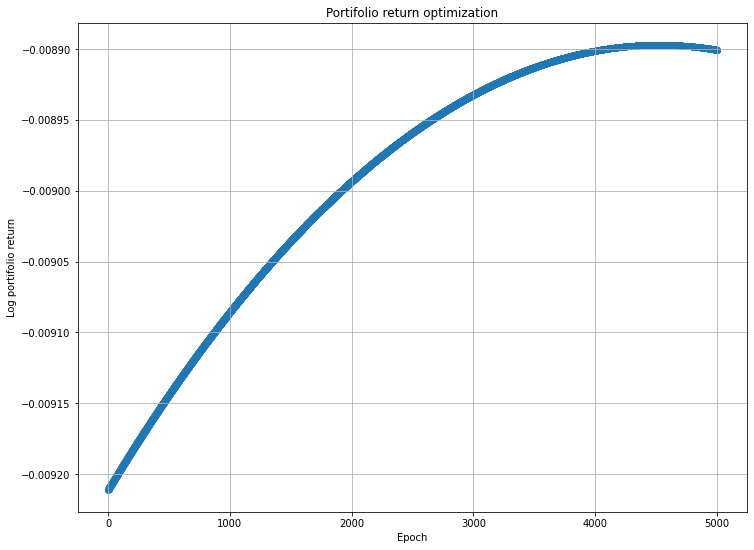

In [15]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

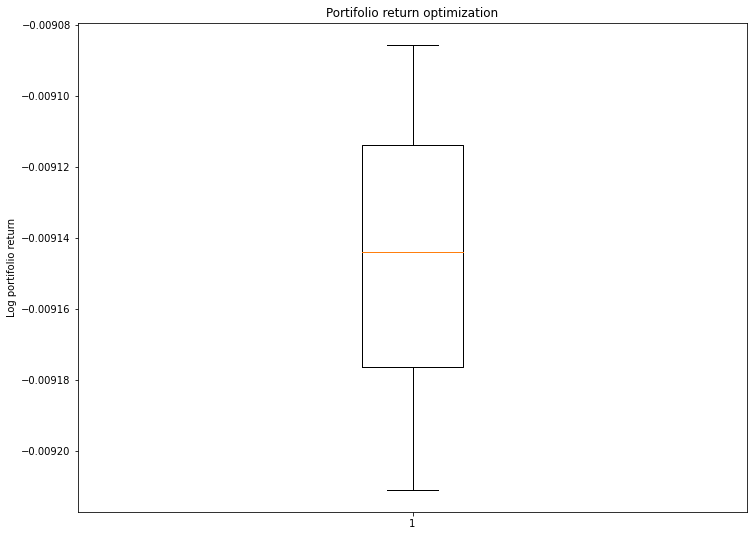

In [231]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

In [193]:
np.random.seed(123)
theta = np.random.rand(1, 3)
# Optmize Theta over all stocks and times
print(f" Theta :{theta}, k:{k}")
r_p_grad=0
r_p = 0
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = theta.dot(firm_df.T)
    # Multiply only t-1 firm characteristics
    # Starting return r at t+1
    r_p_grad += firm_df[:-1].T * r[i, 1:]
    r_p +=  (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
r_p_grad *= (1/number_of_stocks)
u_grad = np.power((1+r_p),-1)
gradient = (np.power(r_p_grad,2) * u_grad).T.sum()/time

 Theta :[[0.69647 0.28614 0.22685]], k:999


In [172]:
u_grad

array([[0.06003, -11.48394, 1.41642, 111823.94733, 18.67257, 0.00892,
        0.31681, -2199857.49098, 89.73039, 42.87565, 0.10950,
        -8680321925.19858, 0.03002, 0.99706, 1.58842, 0.03943, 0.01663,
        6.67741, 0.32979, 0.06531, 0.36862, 13518.14441, 0.13275,
        0.19851, 0.09029, 177.85926, 98.68158, -2.14714, -0.08137,
        -19.81870, 0.11646, 0.04870, -2385.54518, 0.10381, 0.00408,
        2.93466, 15.24832, -4.85434, 56.17823, 0.22065, 0.02866, 0.20418,
        -5093126881.25950, 0.68072, 41.98501, -1076.02299, 99.45976,
        1.02463, 0.08914, 0.18471, 0.14308, 11.56846, 7.95334, -1.85887,
        0.00590, 13.54309, 0.09532, 1.47000, 57.10103, 0.06248, 0.02997,
        0.21878, 588.86804, 0.45482, 0.11685, 0.31649, -13.05337,
        0.39010, 1.08947, -2.22273, 52.39698, 476.27460, 0.06052,
        0.10530, 0.10299, 0.13671, 1.02318, 74.36251, 15.71202, 0.02182,
        -36.25627, 32.79270, -266.96757, 3.13701, 338549.76789, -1.48502,
        0.21271, 2.87157, 0

In [195]:
print(f" Gradient :{gradient.to_numpy()}, k:{k}\n")

 Gradient :[0.28430 0.19256 0.28028], k:999



In [194]:
r_p

array([[0.48458, -0.80195, 0.37804, -0.03618, -0.59875, 0.45590, 0.02266,
        0.09648, -0.06344, -0.03352, 0.08830, -0.24795, 0.07698, 0.19332,
        0.06661, -0.13996, -0.07991, 0.26129, 0.40091, 0.18340, 0.37382,
        -0.11314, -0.30739, 0.37947, 0.03351, 0.24772, 0.25871, -0.25069,
        -0.81209, -0.63062, 0.29334, -0.02888, -0.57670, 0.44221,
        0.45572, 0.20780, 0.00758, -0.18992, -0.28037, 0.17066, 0.06457,
        0.11513, -0.04714, 0.04776, 0.12139, 0.09209, -0.60015, -0.12818,
        -0.24457, 0.12402, 0.22686, -0.17784, -0.42132, -0.06421,
        0.15662, 0.34993, 0.20167, 0.16496, -0.08054, 0.33571, -0.14054,
        0.00604, -0.34237, -0.48716, 0.38927, 0.48429, -0.19010,
        -0.07423, 0.10821, -0.79224, -0.02099, 0.23969, 0.10889, 0.24344,
        -0.03022, 0.37475, 0.25924, 0.07388, 0.29014, -0.11156, -0.27185,
        0.01723, -0.35415, 0.05502, 0.06594, -0.57827, -0.15959,
        -0.36187, 0.12747]])

In [ ]:


# benchmark portifolio weight of stock i on time t
w_i_t_bench = 1.0

# weight of stock i on time t
w_i_t = w_i_t_bench + (1/number_of_stocks)*X.dot(firm_characteristics)

# Where X is a vector of coefficients that we want to find and firm_characteristics are a vector of firm characteristics.


In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [5]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [6]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [40]:
time = 90
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i] + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)

    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [10]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69647, 0.28614, 0.22685]])

In [38]:
from scipy.optimize import minimize

In [65]:
opt_iter = 1
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_r.append(-objective(thetaI))
    opt_iter += 1

In [66]:
sol = minimize(objective, theta0, callback=callback_steps)
sol

i:1, theta i: [-0.06351 0.70841 0.74088], f(theta):1.2131658535421985
i:2, theta i: [-0.20432 0.90021 0.93178], f(theta):0.9978152325831017
i:3, theta i: [-0.52549 1.36168 1.38148], f(theta):0.6731738839743524
i:4, theta i: [-0.91579 1.94000 1.93716], f(theta):0.451484515895554
i:5, theta i: [-1.39522 2.65933 2.62362], f(theta):0.3002525460209777
i:6, theta i: [-1.98102 3.54260 3.46382], f(theta):0.1983528425988593
i:7, theta i: [-2.69483 4.62088 4.48809], f(theta):0.1301370450768914
i:8, theta i: [-3.56019 5.92892 5.72992], f(theta):0.08483774706203423
i:9, theta i: [-4.60438 7.50756 7.22839], f(theta):0.054968658415998156
i:10, theta i: [-5.85825 9.40331 9.02778], f(theta):0.03541244184901504
i:11, theta i: [-7.35715 11.66955 11.17886], f(theta):0.022691391987925764
i:12, theta i: [-9.14152 14.36743 13.73968], f(theta):0.014466088600210095
i:13, theta i: [-11.25767 17.56695 16.77670], f(theta):0.009176830512822358
i:14, theta i: [-13.75844 21.34802 20.36577], f(theta):0.0057930025887

      fun: 0.00033151769537402044
 hess_inv: array([[141944.34195, -214613.46502, -203717.71370],
       [-214613.46502, 324488.78434, 308013.86671],
       [-203717.71370, 308013.86671, 292377.30351]])
      jac: array([0.00001, -0.00000, -0.00001])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([-40.71603, 62.10689, 59.05532])

In [52]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [56]:
np.sum(w, axis=1)/time

array([0.15819, 0.16122, 0.16461, 0.15101, 0.15604, 0.04318, 0.04569,
       0.04182, 0.03599, 0.04225])

In [ ]:
theta

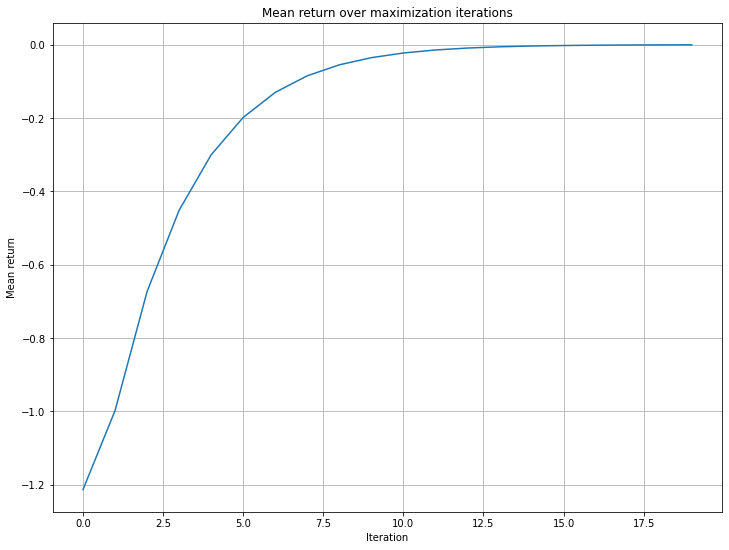

In [77]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return over maximization iterations")
plt.plot(x, mean_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.grid()
plt.show()